# Classifying Cifar-10 using ResNets - Pytorch

- categories: [deep_learning]

## Understanding use of Regularization and Data Augmentation 

## Exploring the CIFAR10 Dataset

CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

*Link*:- https://www.kaggle.com/c/cifar-10

*Dataset-credentials*:- https://www.cs.toronto.edu/~kriz/cifar.html

![image](https://blog.kickview.com/content/images/size/w2000/2016/12/cfar-1.jpg)

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
project_name = 'cifar10-resnet'

In [3]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['ship', 'cat', 'automobile', 'frog', 'airplane', 'dog', 'truck', 'deer', 'bird', 'horse']


## Data Preprocessing

going to use test set for validation

## Channel wise data normalisation

we will normalize the image tensors by substracting the mean and dividing by the standard deviation across each channel. it will mean the data across each channel to 0 and standard deviation to 1. normalizing data prevents the values from any one channel from disproportionately affecting the losses and gradients while training simply by having a higher or wider range of values that others

![normalization](https://i.imgur.com/LYxXBVg.png)

## Randomized data augmentation

Applying chosen transformations while loading images from the training dataset. we will pad each image by 4 pixels and then take a random crop of size 32 x 32 and then flip the image horizontly with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better

![data_aug](https://miro.medium.com/max/2210/1*uwnaDjYuMuYyVK0m-5RcjQ.png)

In [4]:
# Data transforms (normalization and data augmentation)

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), # it is going to shift the image around upto 4 pixels(top/bottom/left/right) each time     
                         tt.RandomHorizontalFlip(), # default probab = 0.5
                         #tt.RandomRotation(),
                         #tt.RandomResizedCrop(256, scale=(0.5, 0.9), ratio=(1, 1)),
                         #tt.ColorJitter(brightness=0.1, contrast =0.1, saturation=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)]) 

# we can not apply transformations to validation set coz it is for testing on real data


we need normalized transformation for validation set too bcoz when we train the model using normalized data then model no longer understands the original pixel values, it only understands the mormalize pixel values which has been shifted using mean and standard deviations, therefore any new input that is used should also contain same normalization

In [5]:
# pytorch datasets

train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [6]:
batch_size = 400

In [7]:
# Pytorch data loaders

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [8]:
# displaying image using denormalizing pixel values

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
        break

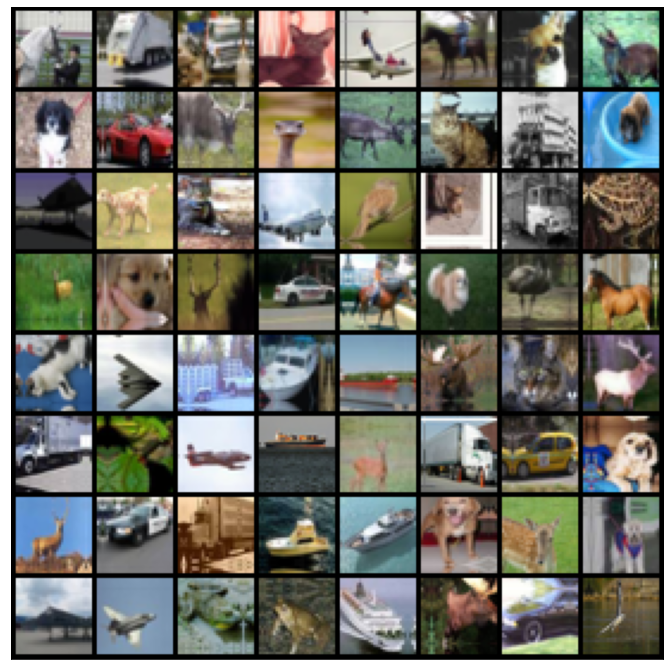

In [9]:
show_batch(train_dl)

## Using a GPU

In [10]:
# check for GPU
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
# function that can move data and model to chosen device

def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)       # to method 

In [13]:
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

we will add residual block, that adds the original input back to the output feature map obtained by passing the input through one or more conv layers

without residual block, these layers are responsible for transforming the input into the output, our entire network in responsible for transforming images 3d rgb 32x32 color images into 10 output class probabilities but when we pass a residual layer then our conv layers are no longer responsible for converting the i/p to o/p rather they only have to calculate the difference between i/p and o/p coz, **final o/p is the o/p of covn layer + i/p so simply o/p of conv layer is desired op - i/p layer**

so the wieghts can learn more powerful features

![residual](https://www.programmersought.com/images/597/31518268d55f9de9021c072e8c80984d.png)

In [15]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
# in a residual block we can not change the no of o/p channels, coz if we change it ex to 128 then we'll not be able to add the orginal i/p to o/p coz then i/p shape and o/p shape would not match        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [16]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    print(images.shape)
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])
torch.Size([400, 3, 32, 32])


Batch Normalization layer: normalizes the o/p of previous layer

some cool resources : [Residual blocks](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec) [Batch Normalization](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd) [ResNet9](https://myrtle.ai/learn/how-to-train-your-resnet/)  

lmao cool animation down there 
**ResNet34** : ![resnet34](https://miro.medium.com/max/632/1*z3JQucKIjgdSpTQ5F1Geew.gif)

Cmon dude see some more about ResNets

**ResNet18** : ![resnet18](https://www.researchgate.net/profile/Md-Atiqul-Islam-Rizvi/publication/334710759/figure/fig3/AS:785018523750403@1564174409893/ResNet-18-architecture-a-basic-building-block-of-residual-learning-b-filter.png)

![fullarchitecture](https://www.researchgate.net/profile/Muhammad-Hasan-27/publication/323063171/figure/fig1/AS:603178554904576@1520820382219/Proposed-Modified-ResNet-18-architecture-for-Bangla-HCR-In-the-diagram-conv-stands-for.png)


## we'll use ResNet9 architecture:

![resnet9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

### bro only diagram above is good for easy understanding so do not ignore it and for clarity --> ctrl + mbtn-up

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
               epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers) # * layers is same as passing one by one args to nn.Sequential

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 400 x 3 x 32 x 32

        self.conv1 = conv_block(in_channels, 64)                # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)            # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), 
                                  conv_block(128, 128))        # 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True)           # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)           # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512),        
                                  conv_block(512, 512))         # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),        # 512 x 1 x 1
                                        nn.Flatten(),           # 512
                                        nn.Dropout(0.2),        # 512 -->used to avoid overfitting
                                        nn.Linear(512, num_classes))  # 10
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [19]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html


### Yo start with a low learning rate and then slowly keeps inc lr so that model keeps making larger steps and then start dec the lr again coz once model approaches the good set of weights  then we want to narrow down and pick the set of weights by taking really small steps towrds that optimal one 

![seethis](https://miro.medium.com/max/1894/1*VAmbyfpR0_-gP0oIla0Vjw.png)
![2nd](https://miro.medium.com/max/952/1*_7CeyMZaolYgmfgbl85dqg.jpeg)

* **Weight decay**: regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

### now Loss = MSE(y_hat, y) + wd * sum(w^2)
When we update weights using gradient descent we do the following:
### w(t) = w(t-1) - lr * dLoss / dw
Now since our loss function has 2 terms in it, the derivative of the 2nd term w.r.t w would be:
### d(wd * w^2) / dw = 2 * wd * w (similar to d(x^2)/dx = 2x)

![wd](https://slideplayer.com/slide/13012436/79/images/34/Regularization+New+loss+function+to+be+minimized+Gradient%3A+Update%3A.jpg)

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

![clip1](https://slidetodoc.com/presentation_image_h/1ca0a61eb2205bba6713c4a711762c8c/image-37.jpg)
![clip2](https://i1.wp.com/neptune.ai/wp-content/uploads/gradient-clipping.png?resize=698%2C331&ssl=1)

In [29]:
# fit_one_cycle function

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()                    # tells model that we are currently evaluating and not training
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history =[]
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses= []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [30]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.5891424417495728, 'val_acc': 0.4678846001625061}]

In [34]:
epochs = 16
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [35]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip=grad_clip, weight_decay = weight_decay)

Epoch [0], last_lr: 0.00138, train_loss: 0.4685, val_loss: 0.5093, val_acc: 0.8230
Epoch [1], last_lr: 0.00394, train_loss: 0.5068, val_loss: 0.5091, val_acc: 0.8308
Epoch [2], last_lr: 0.00703, train_loss: 0.5393, val_loss: 0.8572, val_acc: 0.7250
Epoch [3], last_lr: 0.00935, train_loss: 0.5397, val_loss: 0.6107, val_acc: 0.8067
Epoch [4], last_lr: 0.00999, train_loss: 0.5024, val_loss: 0.5370, val_acc: 0.8198
Epoch [5], last_lr: 0.00972, train_loss: 0.4943, val_loss: 0.6554, val_acc: 0.7915
Epoch [6], last_lr: 0.00908, train_loss: 0.4549, val_loss: 0.4965, val_acc: 0.8401
Epoch [7], last_lr: 0.00812, train_loss: 0.4190, val_loss: 0.7664, val_acc: 0.7785
Epoch [8], last_lr: 0.00691, train_loss: 0.3934, val_loss: 0.4607, val_acc: 0.8482
Epoch [9], last_lr: 0.00556, train_loss: 0.3638, val_loss: 0.4654, val_acc: 0.8466
Epoch [10], last_lr: 0.00416, train_loss: 0.3323, val_loss: 0.4287, val_acc: 0.8637
Epoch [11], last_lr: 0.00283, train_loss: 0.2908, val_loss: 0.3947, val_acc: 0.8729
Ep

In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

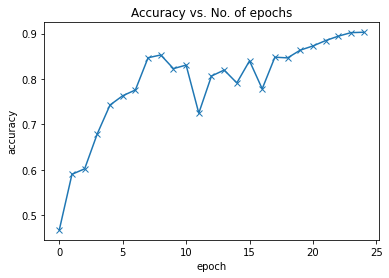

In [43]:
plot_accuracies(history)

In [44]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No of epochs');

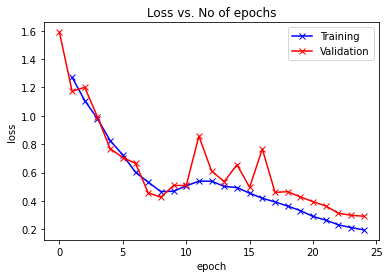

In [45]:
plot_losses(history)

In [46]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs Batch no.');

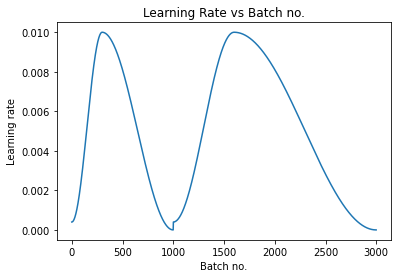

In [47]:
plot_lrs(history)

## Testing with individual images

In [52]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    
    _, pred = torch.max(yb, dim=1)
    
    return train_ds.classes[pred[0].item()]

Label: bird , Predicted: bird


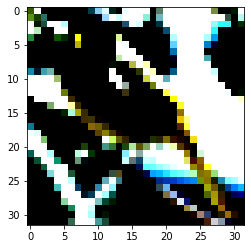

In [54]:
img, label = valid_ds[2341]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: truck


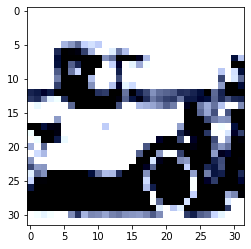

In [55]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: automobile


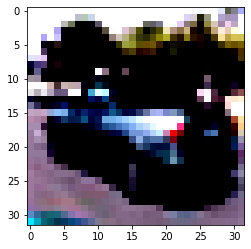

In [58]:
img, label = valid_ds[1111]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: automobile


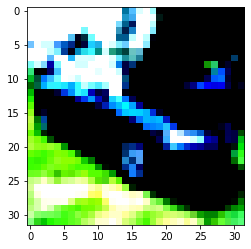

In [59]:
img, label = valid_ds[1921]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

In [60]:
# saving the model

torch.save(model.state_dict(), 'cifar-10-resnet9.pth')